### Ryan's Models

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import sklearn.neural_network
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import print_function

%matplotlib inline

In [2]:
%%time 
"""
Read in train/validate and test as Pandas DataFrames
"""
df_train = pd.read_csv("train")
df_test = pd.read_csv("test")

CPU times: user 1min 10s, sys: 11.9 s, total: 1min 22s
Wall time: 1min 25s


In [3]:
df_train.head()

,smiles,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,feat_009,...,feat_248,feat_249,feat_250,feat_251,feat_252,feat_253,feat_254,feat_255,feat_256,gap
0,c1ccc(o1)-c1ccc(s1)-c1cnc(-c2scc3[se]ccc23)c2n...,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1.19
1,C1=CC=C(C1)c1cc2ncc3c4[SiH2]C=Cc4ncc3c2c2=C[Si...,1,0,0,0,1,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1.60
2,[nH]1c-2c([SiH2]c3cc(-c4scc5C=CCc45)c4nsnc4c-2...,1,0,0,0,1,1,1,0,0,...,1,0,0,0,1,0,0,0,0,1.49
3,[nH]1c2-c3occc3Cc2c2c1cc(-c1cccc3=C[SiH2]C=c13...,1,0,0,0,1,1,1,0,0,...,1,0,0,0,1,0,0,0,0,1.36
4,c1cnc2c3oc4cc(-c5ncncn5)c5nsnc5c4c3c3cocc3c2c1,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1.98


In [4]:
df_test.head()

,Id,smiles,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,...,feat_247,feat_248,feat_249,feat_250,feat_251,feat_252,feat_253,feat_254,feat_255,feat_256
0,1,c1sc(-c2cnc3c(c2)c2nsnc2c2cc4cccnc4cc32)c2cc[n...,0,0,0,0,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
1,2,[nH]1cccc1-c1cc2c3nsnc3c3c4sccc4[nH]c3c2s1,0,0,0,0,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
2,3,[nH]1c2cc(-c3ccc[se]3)c3nsnc3c2c2c3cscc3c3ccc4...,1,0,0,0,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
3,4,[nH]1c(cc2cnc3c(c12)c1=C[SiH2]C=c1c1ccc2=CCC=c...,1,0,0,0,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
4,5,c1sc(-c2sc(-c3sc(-c4scc5[se]ccc45)c4ccoc34)c3c...,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [29]:
#create temporary dataset (subsample of training)
df_temp = df_train.sample(frac=0.10)
Y_temp = df_temp.gap.values 
df_temp = df_temp.drop(['gap'],axis=1).reset_index(drop=True)

## Training-validation split
Having done feature engineering, we split the training data into a training (30%) and validation (70%) set:

__@Max - I think we should be doing somethin like 60% train, 20% validate and 20% test__ : http://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio

In [6]:
def split_df(df, ys, ps):
    """
    df: unaltered (smiles included) pd dataframe
    ys: unaltered yvalues array
    ps: """
    try:
        df = df.drop(["smiles"], axis=1)
    except:
        pass
    try:
        df = df.drop(["molecule"], axis=1)
    except:
        pass
    splits = np.random.choice([0,1,2], size=(len(df)), p=ps)
    df["group"] = splits
    x_train    = df[df["group"] == 0].drop(['group'], axis=1)
    x_validate = df[df["group"] == 1].drop(['group'], axis=1)
    x_test     = df[df["group"] == 2].drop(['group'], axis=1)
    y_train    = [ys[i] for i in range(len(ys)) if splits[i] == 0]
    y_validate = [ys[i] for i in range(len(ys)) if splits[i] == 1]
    y_test     = [ys[i] for i in range(len(ys)) if splits[i] == 2]
    
    return x_train.values, x_validate.values, x_test.values, y_train, y_validate, y_test

In [30]:
X_train, X_validate, X_test, Y_train, Y_validate, Y_test = split_df(df_temp, Y_temp, [.6, .2, .2])

In [31]:
X_train.shape, X_validate.shape, X_test.shape, len(Y_train), len(Y_validate), len(Y_test)

((60105, 256), (19767, 256), (20128, 256), 60105, 19767, 20128)

## Computing RMSE
The sklearn function below computes RMSE, which is the loss function we are minimizing in this practical.

In [32]:
#Create dictionary of RMSEs
try:
    RMSE_dict
except:
    RMSE_dict = {}

In [ ]:
%%time 
LR = LinearRegression()
LR.fit(X_train, Y_train)
#check RMSE on validation set 
LR_val_pred = LR.predict(X_validate)
LR_MSE = mean_squared_error(Y_validate, LR_val_pred)

##LR_pred = LR.predict(X_test)
RMSE_dict['LR_nofeat']=LR_MSE
print(LR_MSE)

### Random Forest Regression

In [33]:
def rf_regress(X_train, Y_train, X_validate, Y_validate,
               n_estimators=10, max_features="auto", bootstrap="true"):
    RF = RandomForestRegressor(n_estimators=n_estimators)
    RF.fit(X_train, Y_train)
    RF_val_pred   = RF.predict(X_validate)
    RF_train_pred = RF.predict(X_train)
    RF_MSE = mean_squared_error(Y_validate,RF_val_pred)
    RF_MSE_train = mean_squared_error(Y_train, RF_train_pred)
    ##RF_pred = RF.predict(X_test)
#     try:
#         RMSE_dict[name].append((RF_MSE, n_estimators, max_features, bootstrap))
#     except:
#         RMSE_dict[name] = [(RF_MSE, n_estimators, max_features, bootstrap)]
    
#     RMSE_dict[name] = (RF_MSE, n_estimators, max_features, bootstrap)
    return RF_MSE_train, RF_MSE
    

In [36]:
%%time
n_estimators = range(1, 41, 2)
RF_train_results    = [None] * len(n_estimators)
RF_validate_results = [None] * len(n_estimators)

for i, n in enumerate(n_estimators):
    RF_train_results[i], RF_validate_results[i] = rf_regress(X_train, Y_train, X_validate, Y_validate, n_estimators=n)
    

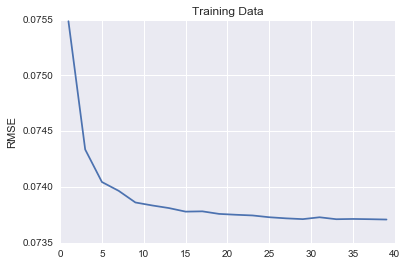

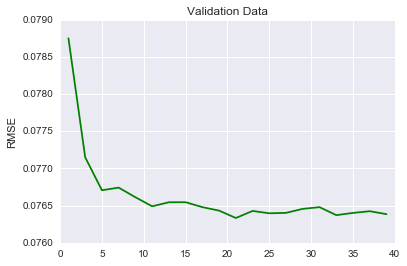

In [43]:
plt.plot(n_estimators, RF_train_results)
plt.ylabel("RMSE")
plt.title("Training Data")
plt.show()
plt.plot(n_estimators, RF_validate_results, c='g')
plt.ylabel("RMSE")
plt.title("Validation Data")

In [ ]:
rf_regress(X_train, Y_train, X_validate, Y_validate, n_estimators=3, name="RF_nofeat")
RMSE_dict